# Final Quantization Benchmark: GPT-2 Small on WikiText-2

**Native-Only Execution**: This notebook only runs quantization formats that are natively supported.

**Formats Tested:**
- FP32 (Baseline)
- FP16 (Half Precision)

**Model**: GPT-2 Small (124M parameters)

**Task**: Language Modeling (WikiText-2)

**Metrics:**
- Latency (ms/sample)
- Throughput (samples/second)
- Perplexity (lower is better)
- Energy (mJ/sample)
- Power (W)
- Model Size (MB)

## Setup and Imports

In [25]:
!git clone https://github.com/krishkc5/energy_aware_quantization

fatal: destination path 'energy_aware_quantization' already exists and is not an empty directory.


In [26]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import threading
import subprocess
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4
CUDA version: 12.4


## Check Native Format Support

In [27]:
# Check which formats are natively supported
device = "cuda" if torch.cuda.is_available() else "cpu"

# FP32 and FP16 are always supported on CUDA
FP32_SUPPORTED = True
FP16_SUPPORTED = torch.cuda.is_available()

print("="*70)
print("NATIVE FORMAT SUPPORT")
print("="*70)
print(f"FP32:            {'✓ Supported' if FP32_SUPPORTED else '✗ Not supported'}")
print(f"FP16:            {'✓ Supported' if FP16_SUPPORTED else '✗ Not supported'}")
print("="*70)

# Build list of formats to test
FORMATS_TO_TEST = []
if FP32_SUPPORTED:
    FORMATS_TO_TEST.append('fp32')
if FP16_SUPPORTED:
    FORMATS_TO_TEST.append('fp16')

print(f"\nFormats to benchmark: {FORMATS_TO_TEST}")

NATIVE FORMAT SUPPORT
FP32:            ✓ Supported
FP16:            ✓ Supported

Formats to benchmark: ['fp32', 'fp16']


## Load Pre-Tokenized Dataset

In [28]:
import os
import json
cwd = os.getcwd()

# Search for tokenized dataset
possible_paths = [
    Path(cwd) / ".." / "datasets" / "gpt2_tokenized_data",
    Path(cwd) / "datasets" / "gpt2_tokenized_data",
    Path(cwd) / "energy_aware_quantization" / "datasets" / "gpt2_tokenized_data",
    Path("/kaggle/working/gpt2_tokenized_data"),
]

dataset_path = None
for path in possible_paths:
    if path.exists() and (path / "input_ids.pt").exists():
        dataset_path = path
        break

if dataset_path is None:
    current = Path(cwd)
    for _ in range(5):
        test_path = current / "datasets" / "gpt2_tokenized_data"
        if test_path.exists() and (test_path / "input_ids.pt").exists():
            dataset_path = test_path
            break
        current = current.parent

if dataset_path is None:
    raise FileNotFoundError("Could not find GPT-2 tokenized dataset. Please run gpt2_tokenized_dataset.ipynb first.")

print(f"Loading dataset from: {dataset_path}")

# Load tensors
input_ids = torch.load(dataset_path / "input_ids.pt", map_location='cpu')
attention_mask = torch.load(dataset_path / "attention_mask.pt", map_location='cpu')
labels = torch.load(dataset_path / "labels.pt", map_location='cpu')

print(f"✓ Loaded {input_ids.shape[0]} samples")
print(f"  Input shape: {input_ids.shape}")
print(f"  Device: {input_ids.device}")

Loading dataset from: /kaggle/working/energy_aware_quantization/datasets/gpt2_tokenized_data
✓ Loaded 1940 samples
  Input shape: torch.Size([1940, 128])
  Device: cpu


## Power Monitoring Utility

In [29]:
class PowerLogger:
    """Background thread for GPU power monitoring using nvidia-smi"""
    
    def __init__(self, poll_interval_ms=50):
        self.poll_interval_ms = poll_interval_ms
        self.power_samples = []
        self.running = False
        self.thread = None
        
    def _monitor_power(self):
        """Background monitoring loop"""
        while self.running:
            try:
                result = subprocess.run(
                    ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits', '--id=0'],
                    capture_output=True,
                    text=True,
                    timeout=1.0
                )
                if result.returncode == 0:
                    # Parse only the first line (GPU 0) and handle multiple values
                    output = result.stdout.strip().split('\n')[0].strip()
                    power_w = float(output)
                    self.power_samples.append(power_w)
            except Exception as e:
                # Silently skip failed reads during monitoring
                pass
            
            time.sleep(self.poll_interval_ms / 1000.0)
    
    def start(self):
        """Start power monitoring in background thread"""
        self.power_samples = []
        self.running = True
        self.thread = threading.Thread(target=self._monitor_power, daemon=True)
        self.thread.start()
    
    def stop(self):
        """Stop power monitoring and return statistics"""
        self.running = False
        if self.thread:
            self.thread.join(timeout=2.0)
        
        if len(self.power_samples) == 0:
            return {'mean_power_w': 0, 'std_power_w': 0, 'num_samples': 0}
        
        return {
            'mean_power_w': np.mean(self.power_samples),
            'std_power_w': np.std(self.power_samples),
            'num_samples': len(self.power_samples)
        }

# Test power logger
if torch.cuda.is_available():
    print("Testing power logger...")
    logger = PowerLogger(poll_interval_ms=50)
    logger.start()
    time.sleep(1.0)
    stats = logger.stop()
    print(f"✓ Power logger working: {stats['mean_power_w']:.2f}W (n={stats['num_samples']} samples)")
else:
    print("⚠️  GPU not available, power monitoring disabled")

Testing power logger...
✓ Power logger working: 9.77W (n=13 samples)


## Model Loading Functions

In [30]:
MODEL_NAME = "gpt2"

def load_model(precision: str, device: str = "cuda"):
    """
    Load GPT-2 model with specified precision.
    
    Args:
        precision: 'fp32' or 'fp16'
        device: 'cuda' or 'cpu'
    
    Returns:
        model, model_size_mb
    """
    print(f"Loading {precision.upper()} model...")
    
    model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)
    
    # Apply precision
    if precision == 'fp16':
        model = model.half()

    model = model.to(device)
    model.eval()
    
    # Calculate model size
    model_size_mb = sum(p.element_size() * p.nelement() for p in model.parameters()) / (1024 ** 2)
    
    print(f"  ✓ Size: {model_size_mb:.2f} MB")
    print(f"  ✓ Dtype: {next(model.parameters()).dtype}")
    
    return model, model_size_mb

## Benchmark Function (Lab 3 Methodology)

In [31]:
def benchmark_model(
    model,
    input_ids,
    attention_mask,
    labels,
    name: str,
    device: str,
    num_iters: int = 100,
    warmup_iters: int = 10
):
    """
    Benchmark GPT-2 model following Lab 3 methodology.
    
    4-phase process:
    1. Warmup
    2. Start power logger
    3. Run benchmark (measure latency + perplexity)
    4. Compute metrics
    """
    print(f"\n{'='*70}")
    print(f"Benchmarking: {name}")
    print(f"{'='*70}")
    
    # Move data to device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    
    num_samples = input_ids.shape[0]
    
    # [PHASE 1/4] Warmup
    print(f"[1/4] Warmup ({warmup_iters} iterations)...")
    with torch.no_grad():
        for i in range(warmup_iters):
            idx = i % num_samples
            sample_input = input_ids[idx].unsqueeze(0)
            sample_mask = attention_mask[idx].unsqueeze(0)
            
            _ = model(input_ids=sample_input, attention_mask=sample_mask)
    
    if device == "cuda":
        torch.cuda.synchronize()
    
    # [PHASE 2/4] Start power logger
    print(f"[2/4] Starting power logger...")
    power_logger = None
    if device == "cuda":
        power_logger = PowerLogger(poll_interval_ms=50)
        power_logger.start()
        time.sleep(0.5)  # Let logger stabilize
    
    # [PHASE 3/4] Run benchmark
    print(f"[3/4] Running benchmark ({num_iters} iterations)...")
    latencies = []
    total_loss = 0
    num_tokens = 0
    
    benchmark_start = time.perf_counter()
    
    with torch.no_grad():
        for i in range(num_iters):
            # Cycle through dataset
            idx = i % num_samples
            sample_input = input_ids[idx].unsqueeze(0)
            sample_mask = attention_mask[idx].unsqueeze(0)
            sample_labels = labels[idx].unsqueeze(0)
            
            if device == "cuda":
                torch.cuda.synchronize()
            
            iter_start = time.perf_counter()
            
            outputs = model(
                input_ids=sample_input,
                attention_mask=sample_mask,
                labels=sample_labels
            )
            
            if device == "cuda":
                torch.cuda.synchronize()
            
            iter_end = time.perf_counter()
            latencies.append((iter_end - iter_start) * 1000)  # Convert to ms
            
            # Accumulate loss and tokens for perplexity calculation
            # outputs.loss is already averaged per token, so we need to weight by num_tokens
            if outputs.loss is not None:
                batch_tokens = sample_mask.sum().item()
                # Weight the loss by number of tokens (since loss is already per-token average)
                total_loss += outputs.loss.item() * batch_tokens
                num_tokens += batch_tokens
    
    benchmark_end = time.perf_counter()
    benchmark_duration = benchmark_end - benchmark_start
    
    # [PHASE 4/4] Stop power logger and compute metrics
    print(f"[4/4] Computing metrics...")
    power_stats = {'mean_power_w': 0, 'std_power_w': 0, 'num_samples': 0}
    if power_logger:
        time.sleep(0.5)  # Capture trailing samples
        power_stats = power_logger.stop()
    
    # Compute latency statistics
    latencies = np.array(latencies)
    mean_latency_ms = float(np.mean(latencies))
    std_latency_ms = float(np.std(latencies))
    
    # Compute throughput
    throughput = num_iters / benchmark_duration  # samples per second
    
    # Compute tokens per second
    tokens_per_sec = num_tokens / benchmark_duration if benchmark_duration > 0 else 0
    
    # Compute perplexity
    # total_loss is the sum of (loss * num_tokens) for each batch
    # So we divide by total tokens to get the average loss per token
    if num_tokens > 0 and total_loss > 0:
        avg_loss = total_loss / num_tokens
        perplexity = float(np.exp(avg_loss))
    else:
        perplexity = float('inf')
    
    # Compute energy per sample
    if power_stats['num_samples'] > 0 and benchmark_duration > 0:
        mean_power_w = power_stats['mean_power_w']
        energy_per_sample_mj = (mean_power_w * benchmark_duration / num_iters) * 1000  # Convert to mJ
    else:
        energy_per_sample_mj = 0.0
        mean_power_w = 0.0
    
    # Build results dictionary
    results = {
        'name': name,
        'mean_latency_ms': mean_latency_ms,
        'std_latency_ms': std_latency_ms,
        'throughput': throughput,
        'tokens_per_sec': tokens_per_sec,
        'perplexity': perplexity,
        'mean_power_w': mean_power_w,
        'energy_per_sample_mj': energy_per_sample_mj,
    }
    
    print(f"  ✓ Mean latency: {mean_latency_ms:.3f} ± {std_latency_ms:.3f} ms")
    print(f"  ✓ Throughput: {throughput:.2f} samples/sec")
    print(f"  ✓ Perplexity: {perplexity:.2f}")
    if energy_per_sample_mj > 0:
        print(f"  ✓ Energy: {energy_per_sample_mj:.2f} mJ/sample")
    
    return results



## Run All Benchmarks

In [32]:
all_results = []
model_sizes = {}

for precision in FORMATS_TO_TEST:
    try:
        # Load model
        model, model_size_mb = load_model(precision, device=device)
        model_sizes[precision] = model_size_mb
        
        # Benchmark
        results = benchmark_model(
            model=model,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            name=precision.upper(),
            device=device,
            num_iters=100,
            warmup_iters=10,
        )
        
        results['model_size_mb'] = model_size_mb
        all_results.append(results)
        
        # Clean up
        del model
        if device == "cuda":
            torch.cuda.empty_cache()
        
        # Small delay between benchmarks
        time.sleep(2)
        
    except Exception as e:
        print(f"\n❌ Error benchmarking {precision}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"\n{'='*70}")
print("ALL BENCHMARKS COMPLETE")
print(f"{'='*70}")

Loading FP32 model...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

  ✓ Size: 474.70 MB
  ✓ Dtype: torch.float32

Benchmarking: FP32
[1/4] Warmup (10 iterations)...
[2/4] Starting power logger...


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


[3/4] Running benchmark (100 iterations)...
[4/4] Computing metrics...
  ✓ Mean latency: 12.438 ± 4.920 ms
  ✓ Throughput: 78.07 samples/sec
  ✓ Perplexity: 104.43
  ✓ Energy: 655.32 mJ/sample
Loading FP16 model...
  ✓ Size: 237.35 MB
  ✓ Dtype: torch.float16

Benchmarking: FP16
[1/4] Warmup (10 iterations)...
[2/4] Starting power logger...
[3/4] Running benchmark (100 iterations)...
[4/4] Computing metrics...
  ✓ Mean latency: 11.409 ± 0.661 ms
  ✓ Throughput: 86.57 samples/sec
  ✓ Perplexity: 104.47
  ✓ Energy: 392.18 mJ/sample

ALL BENCHMARKS COMPLETE


## Results Summary Table

In [33]:
# Create results dataframe
df_results = pd.DataFrame(all_results)

# Calculate speedup vs FP32
if 'fp32' in [r['name'].lower() for r in all_results]:
    fp32_latency = df_results[df_results['name'].str.upper() == 'FP32']['mean_latency_ms'].values[0]
    df_results['speedup_vs_fp32'] = fp32_latency / df_results['mean_latency_ms']
    
    fp32_energy = df_results[df_results['name'].str.upper() == 'FP32']['energy_per_sample_mj'].values[0]
    if fp32_energy > 0:
        df_results['energy_reduction_vs_fp32'] = fp32_energy / df_results['energy_per_sample_mj']
    else:
        df_results['energy_reduction_vs_fp32'] = 1.0
    
    fp32_size = df_results[df_results['name'].str.upper() == 'FP32']['model_size_mb'].values[0]
    df_results['size_reduction_vs_fp32'] = fp32_size / df_results['model_size_mb']
else:
    df_results['speedup_vs_fp32'] = 1.0
    df_results['energy_reduction_vs_fp32'] = 1.0
    df_results['size_reduction_vs_fp32'] = 1.0

# Reorder columns
column_order = [
    'name',
    'mean_latency_ms',
    'std_latency_ms',
    'speedup_vs_fp32',
    'throughput',
    'tokens_per_sec',
    'perplexity',
    'mean_power_w',
    'energy_per_sample_mj',
    'energy_reduction_vs_fp32',
    'model_size_mb',
    'size_reduction_vs_fp32'
]
df_results = df_results[column_order]

# Display results
print("\n" + "="*100)
print("GPT-2 QUANTIZATION BENCHMARK RESULTS")
print("="*100)
print(df_results.to_string(index=False))
print("="*100)


GPT-2 QUANTIZATION BENCHMARK RESULTS
name  mean_latency_ms  std_latency_ms  speedup_vs_fp32  throughput  tokens_per_sec  perplexity  mean_power_w  energy_per_sample_mj  energy_reduction_vs_fp32  model_size_mb  size_reduction_vs_fp32
FP32        12.437972        4.919752         1.000000   78.072561     7945.444543  104.425407     51.162667            655.321997                  1.000000     474.700195                     1.0
FP16        11.408973        0.661476         1.090192   86.568102     8810.035713  104.466943     33.950000            392.176787                  1.670986     237.350098                     2.0


## Statistical Analysis

In [34]:
print("\n" + "="*70)
print("STATISTICAL ANALYSIS")
print("="*70)

# Summary statistics
print("\n1. Latency Statistics (ms/sample):")
for _, row in df_results.iterrows():
    print(f"  {row['name']:12s}: {row['mean_latency_ms']:7.3f} ± {row['std_latency_ms']:6.3f}")

print("\n2. Speedup vs FP32:")
for _, row in df_results.iterrows():
    speedup = row['speedup_vs_fp32']
    print(f"  {row['name']:12s}: {speedup:.2f}x faster")

print("\n3. Energy Efficiency vs FP32:")
for _, row in df_results.iterrows():
    if row['energy_per_sample_mj'] > 0:
        reduction = row['energy_reduction_vs_fp32']
        print(f"  {row['name']:12s}: {reduction:.2f}x more efficient ({row['energy_per_sample_mj']:.2f} mJ/sample)")

print("\n4. Model Size Reduction:")
for _, row in df_results.iterrows():
    reduction = row['size_reduction_vs_fp32']
    print(f"  {row['name']:12s}: {reduction:.2f}x smaller ({row['model_size_mb']:.2f} MB)")

print("\n5. Perplexity Comparison (lower is better):")
for _, row in df_results.iterrows():
    print(f"  {row['name']:12s}: {row['perplexity']:.2f}")

# Best performer in each category
print("\n6. Best Performers:")
if len(df_results) > 1:
    fastest = df_results.loc[df_results['mean_latency_ms'].idxmin()]
    print(f"  Fastest:          {fastest['name']} ({fastest['mean_latency_ms']:.3f} ms)")
    
    most_efficient = df_results.loc[df_results['energy_per_sample_mj'].idxmin()]
    if most_efficient['energy_per_sample_mj'] > 0:
        print(f"  Most Efficient:   {most_efficient['name']} ({most_efficient['energy_per_sample_mj']:.2f} mJ/sample)")
    
    smallest = df_results.loc[df_results['model_size_mb'].idxmin()]
    print(f"  Smallest:         {smallest['name']} ({smallest['model_size_mb']:.2f} MB)")
    
    best_perplexity = df_results.loc[df_results['perplexity'].idxmin()]
    print(f"  Best Perplexity:  {best_perplexity['name']} ({best_perplexity['perplexity']:.2f})")

print("="*70)


STATISTICAL ANALYSIS

1. Latency Statistics (ms/sample):
  FP32        :  12.438 ±  4.920
  FP16        :  11.409 ±  0.661

2. Speedup vs FP32:
  FP32        : 1.00x faster
  FP16        : 1.09x faster

3. Energy Efficiency vs FP32:
  FP32        : 1.00x more efficient (655.32 mJ/sample)
  FP16        : 1.67x more efficient (392.18 mJ/sample)

4. Model Size Reduction:
  FP32        : 1.00x smaller (474.70 MB)
  FP16        : 2.00x smaller (237.35 MB)

5. Perplexity Comparison (lower is better):
  FP32        : 104.43
  FP16        : 104.47

6. Best Performers:
  Fastest:          FP16 (11.409 ms)
  Most Efficient:   FP16 (392.18 mJ/sample)
  Smallest:         FP16 (237.35 MB)
  Best Perplexity:  FP32 (104.43)


## Visualization

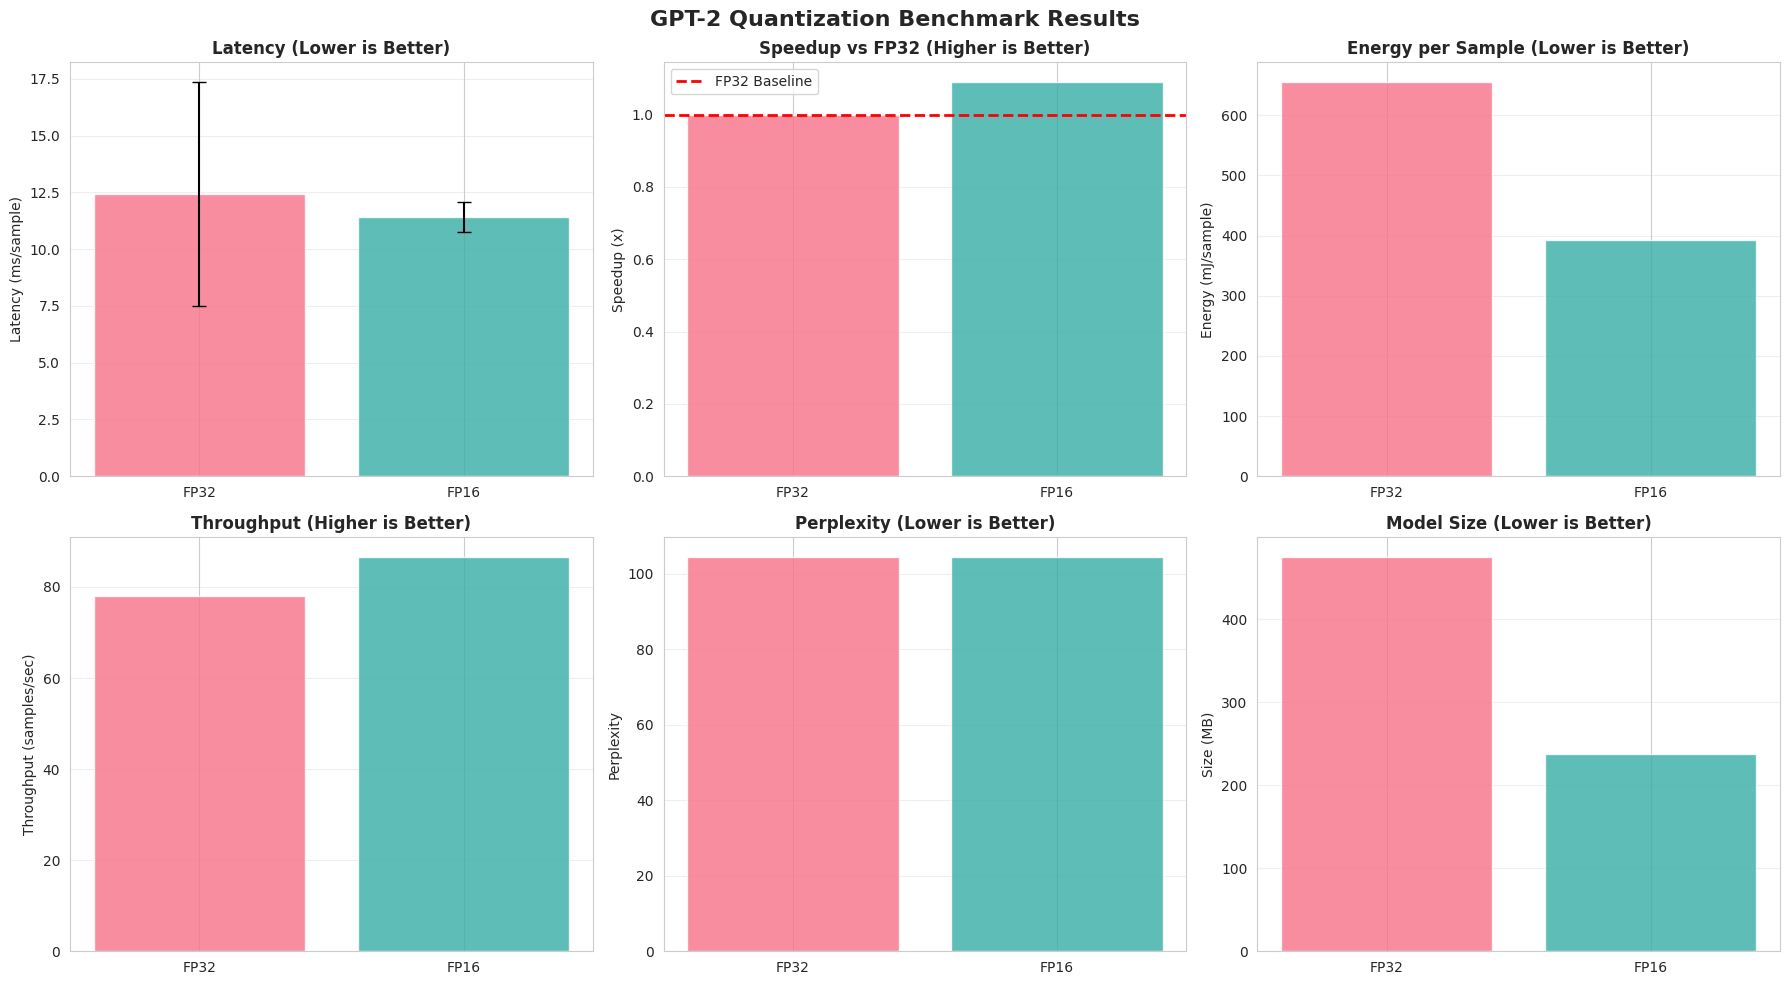


✓ Visualization complete


In [35]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('GPT-2 Quantization Benchmark Results', fontsize=16, fontweight='bold')

# Color palette
colors = sns.color_palette('husl', n_colors=len(df_results))

# 1. Latency comparison
ax = axes[0, 0]
bars = ax.bar(df_results['name'], df_results['mean_latency_ms'], color=colors, alpha=0.8)
ax.errorbar(df_results['name'], df_results['mean_latency_ms'], 
            yerr=df_results['std_latency_ms'], fmt='none', color='black', capsize=5)
ax.set_title('Latency (Lower is Better)', fontweight='bold')
ax.set_ylabel('Latency (ms/sample)')
ax.grid(axis='y', alpha=0.3)

# 2. Speedup vs FP32
ax = axes[0, 1]
bars = ax.bar(df_results['name'], df_results['speedup_vs_fp32'], color=colors, alpha=0.8)
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='FP32 Baseline')
ax.set_title('Speedup vs FP32 (Higher is Better)', fontweight='bold')
ax.set_ylabel('Speedup (x)')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 3. Energy per sample
ax = axes[0, 2]
if df_results['energy_per_sample_mj'].max() > 0:
    bars = ax.bar(df_results['name'], df_results['energy_per_sample_mj'], color=colors, alpha=0.8)
    ax.set_title('Energy per Sample (Lower is Better)', fontweight='bold')
    ax.set_ylabel('Energy (mJ/sample)')
    ax.grid(axis='y', alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Energy data not available', 
            ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Energy per Sample', fontweight='bold')

# 4. Throughput
ax = axes[1, 0]
bars = ax.bar(df_results['name'], df_results['throughput'], color=colors, alpha=0.8)
ax.set_title('Throughput (Higher is Better)', fontweight='bold')
ax.set_ylabel('Throughput (samples/sec)')
ax.grid(axis='y', alpha=0.3)

# 5. Perplexity
ax = axes[1, 1]
bars = ax.bar(df_results['name'], df_results['perplexity'], color=colors, alpha=0.8)
ax.set_title('Perplexity (Lower is Better)', fontweight='bold')
ax.set_ylabel('Perplexity')
ax.grid(axis='y', alpha=0.3)

# 6. Model size
ax = axes[1, 2]
bars = ax.bar(df_results['name'], df_results['model_size_mb'], color=colors, alpha=0.8)
ax.set_title('Model Size (Lower is Better)', fontweight='bold')
ax.set_ylabel('Size (MB)')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

## Pareto Frontier: Speed vs Perplexity

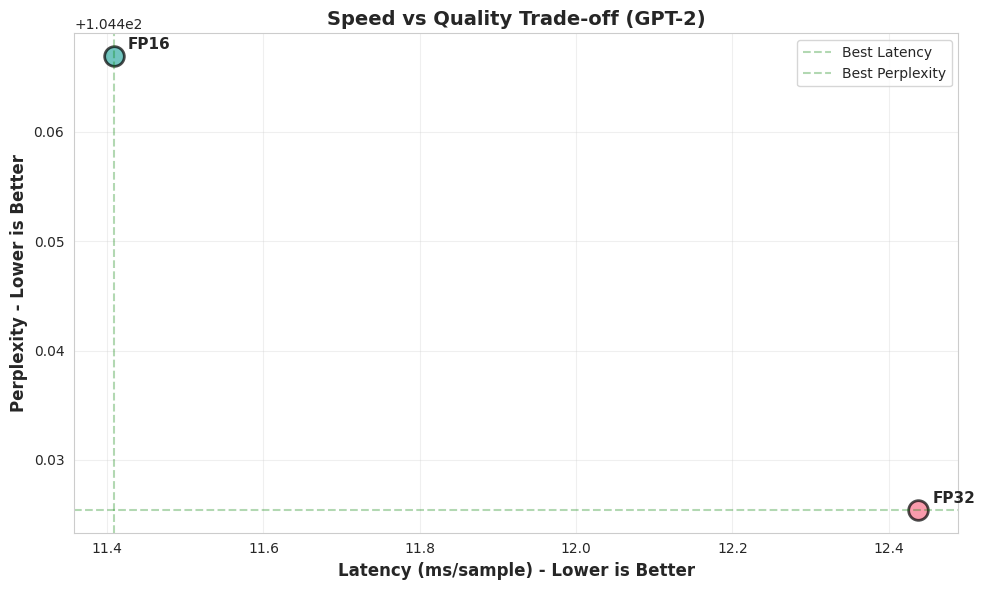


✓ Pareto frontier visualization complete


In [36]:
# Pareto frontier plot: Latency vs Perplexity
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each format
for i, row in df_results.iterrows():
    ax.scatter(row['mean_latency_ms'], row['perplexity'], 
              s=200, c=[colors[i]], alpha=0.7, edgecolors='black', linewidth=2)
    ax.annotate(row['name'], 
               (row['mean_latency_ms'], row['perplexity']),
               xytext=(10, 5), textcoords='offset points',
               fontsize=11, fontweight='bold')

ax.set_xlabel('Latency (ms/sample) - Lower is Better', fontsize=12, fontweight='bold')
ax.set_ylabel('Perplexity - Lower is Better', fontsize=12, fontweight='bold')
ax.set_title('Speed vs Quality Trade-off (GPT-2)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add ideal region (bottom-left corner)
ax.axvline(x=df_results['mean_latency_ms'].min(), color='green', 
          linestyle='--', alpha=0.3, label='Best Latency')
ax.axhline(y=df_results['perplexity'].min(), color='green', 
          linestyle='--', alpha=0.3, label='Best Perplexity')
ax.legend()

plt.tight_layout()
plt.show()

print("\n✓ Pareto frontier visualization complete")

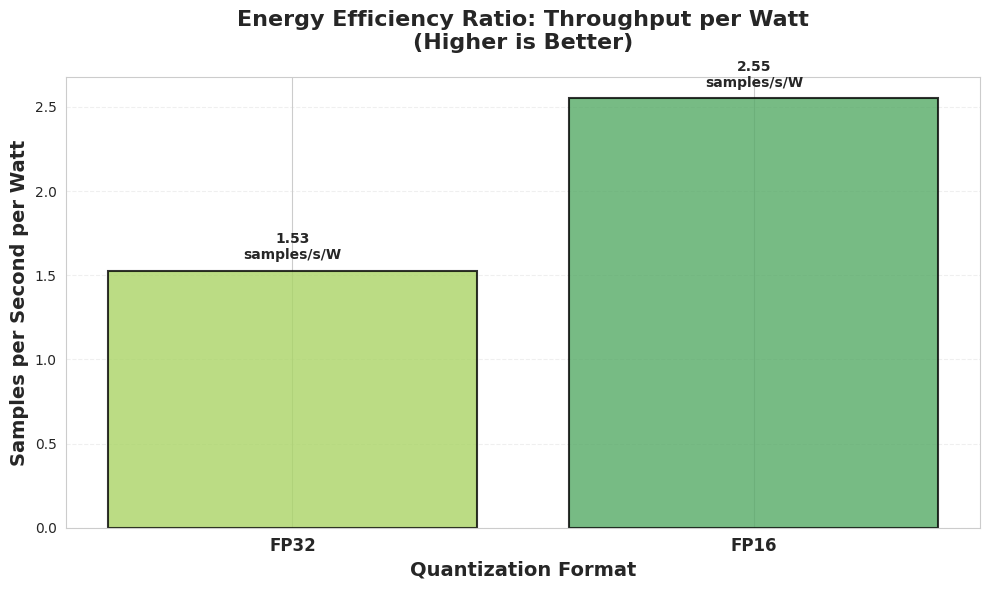

In [37]:
if df_results['mean_power_w'].max() > 0:
    # Calculate efficiency ratio: throughput per watt
    df_results['efficiency_ratio'] = df_results['throughput'] / df_results['mean_power_w']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette('summer', n_colors=len(df_results))[::-1]
    
    x_pos = np.arange(len(df_results))
    bars = ax.bar(x_pos, df_results['efficiency_ratio'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Quantization Format', fontsize=14, fontweight='bold')
    ax.set_ylabel('Samples per Second per Watt', fontsize=14, fontweight='bold')
    ax.set_title('Energy Efficiency Ratio: Throughput per Watt\n(Higher is Better)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(df_results['name'], fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(df_results.iterrows()):
        ax.text(i, row['efficiency_ratio'] + max(df_results['efficiency_ratio'])*0.02, 
                f"{row['efficiency_ratio']:.2f}\nsamples/s/W", 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Power data not available - skipping Efficiency Ratio plot")

### Figure 15: Efficiency Ratio (Throughput per Watt)

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize metrics to 0-100 scale (higher is better)
def normalize_metric(values, inverse=False):
    """Normalize to 0-100 scale. If inverse=True, smaller values are better."""
    min_val, max_val = values.min(), values.max()
    if max_val == min_val:
        return np.ones_like(values) * 50
    
    normalized = (values - min_val) / (max_val - min_val) * 100
    if inverse:
        normalized = 100 - normalized
    return normalized

### Figure 14: Overall Performance Score

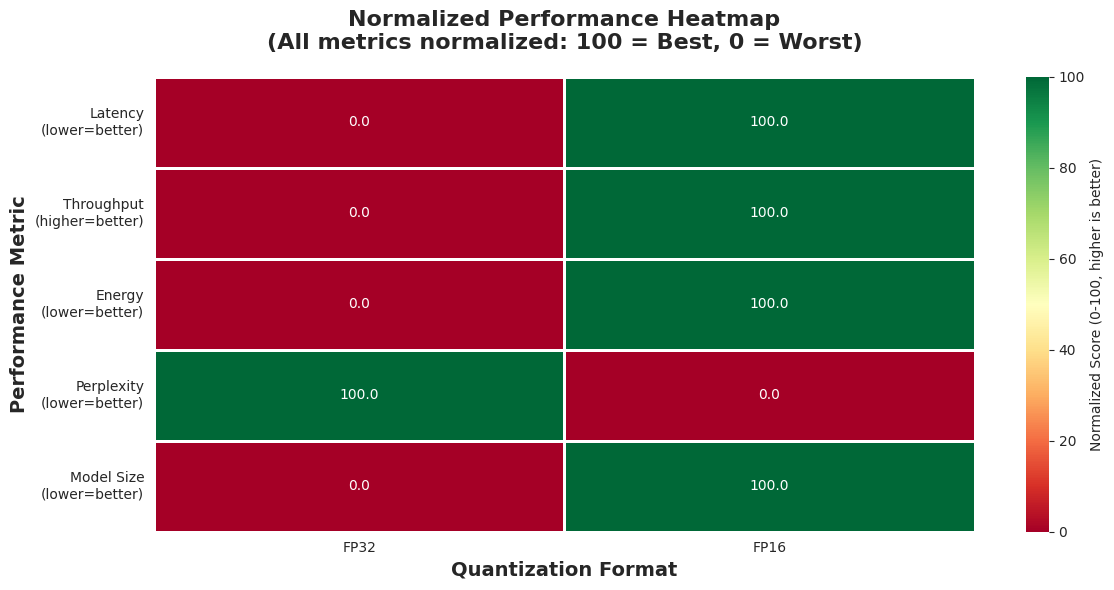

In [39]:
# Create normalized heatmap data
heatmap_data = pd.DataFrame({
    'Latency\n(lower=better)': normalize_metric(df_results['mean_latency_ms'].values, inverse=True),
    'Throughput\n(higher=better)': normalize_metric(df_results['throughput'].values, inverse=False),
    'Energy\n(lower=better)': normalize_metric(df_results['energy_per_sample_mj'].values, inverse=True) if df_results['energy_per_sample_mj'].max() > 0 else np.ones(len(df_results)) * 50,
    'Perplexity\n(lower=better)': normalize_metric(df_results['perplexity'].values, inverse=True),
    'Model Size\n(lower=better)': normalize_metric(df_results['model_size_mb'].values, inverse=True),
})
heatmap_data.index = df_results['name'].values

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(heatmap_data.T, annot=True, fmt='.1f', cmap='RdYlGn', 
            cbar_kws={'label': 'Normalized Score (0-100, higher is better)'}, 
            linewidths=2, linecolor='white', ax=ax, 
            vmin=0, vmax=100, center=50)

ax.set_title('Normalized Performance Heatmap\n(All metrics normalized: 100 = Best, 0 = Worst)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Quantization Format', fontsize=14, fontweight='bold')
ax.set_ylabel('Performance Metric', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

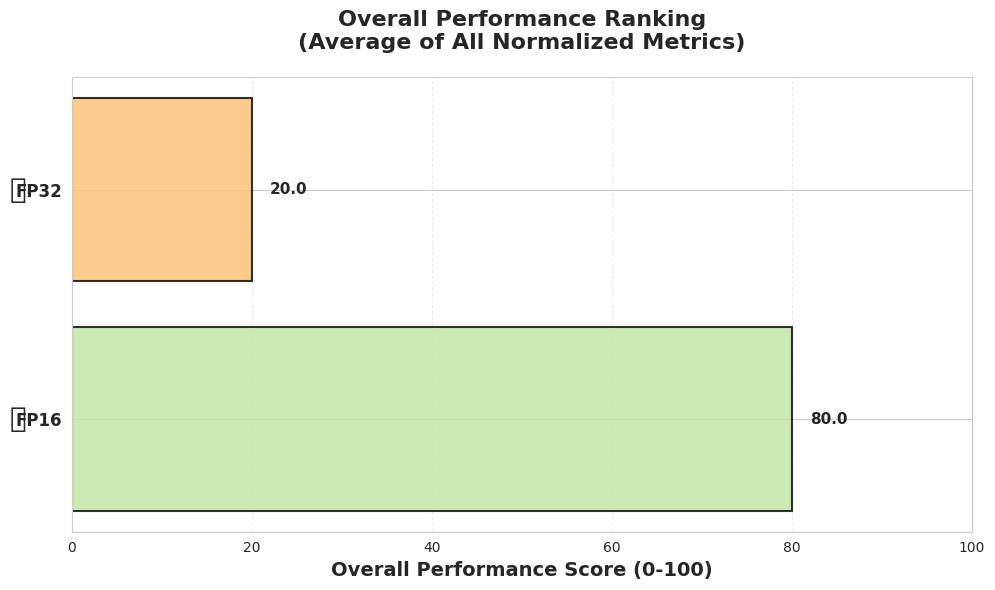


OVERALL PERFORMANCE RANKING
🥇    FP16           : 80.0/100
🥈    FP32           : 20.0/100


In [40]:
# Calculate overall score (average of all normalized metrics)
overall_scores = heatmap_data.mean(axis=1).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors_ranked = sns.color_palette('Spectral', n_colors=len(overall_scores))[::-1]

bars = ax.barh(range(len(overall_scores)), overall_scores.values, color=colors_ranked, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_yticks(range(len(overall_scores)))
ax.set_yticklabels(overall_scores.index, fontsize=12, fontweight='bold')
ax.set_xlabel('Overall Performance Score (0-100)', fontsize=14, fontweight='bold')
ax.set_title('Overall Performance Ranking\n(Average of All Normalized Metrics)', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_xlim(0, 100)

# Add value labels
for i, (name, score) in enumerate(overall_scores.items()):
    ax.text(score + 2, i, f'{score:.1f}', 
            va='center', fontsize=11, fontweight='bold')

# Add rank medals
medals = ['🥇', '🥈', '🥉']
for i in range(min(3, len(overall_scores))):
    ax.text(-5, i, medals[i], fontsize=20, va='center', ha='right')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("OVERALL PERFORMANCE RANKING")
print("="*70)
for i, (name, score) in enumerate(overall_scores.items(), 1):
    medal = medals[i-1] if i <= 3 else f"{i}."
    print(f"{medal:4s} {name:15s}: {score:.1f}/100")
print("="*70)

### Figure 13: Normalized Performance Heatmap

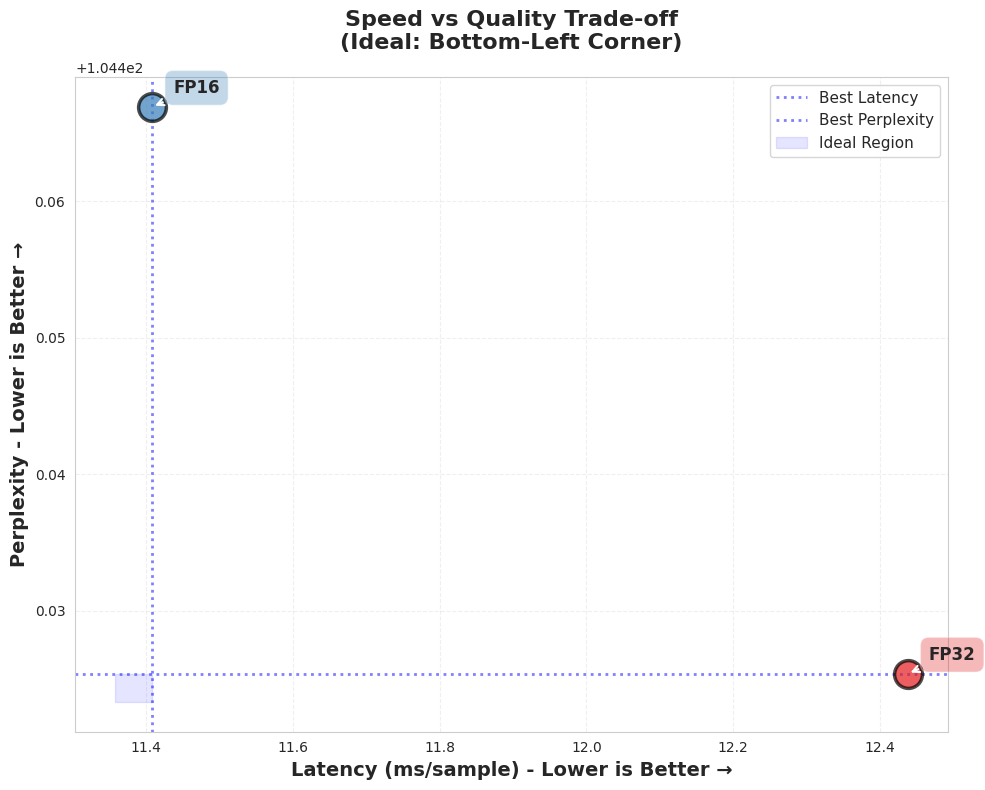

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))
colors = sns.color_palette('Set1', n_colors=len(df_results))

# Scatter plot
for i, row in df_results.iterrows():
    ax.scatter(row['mean_latency_ms'], row['perplexity'], 
              s=400, c=[colors[i]], alpha=0.7, edgecolors='black', linewidth=2.5, zorder=3)
    
    # Add labels
    ax.annotate(row['name'], 
               (row['mean_latency_ms'], row['perplexity']),
               xytext=(15, 10), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.3),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1.5))

ax.set_xlabel('Latency (ms/sample) - Lower is Better →', fontsize=14, fontweight='bold')
ax.set_ylabel('Perplexity - Lower is Better →', fontsize=14, fontweight='bold')
ax.set_title('Speed vs Quality Trade-off\n(Ideal: Bottom-Left Corner)', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Add reference lines
best_latency = df_results['mean_latency_ms'].min()
best_perplexity = df_results['perplexity'].min()

ax.axvline(x=best_latency, color='blue', linestyle=':', linewidth=2, alpha=0.5, label='Best Latency')
ax.axhline(y=best_perplexity, color='blue', linestyle=':', linewidth=2, alpha=0.5, label='Best Perplexity')

# Shade ideal quadrant
ax.fill_between([ax.get_xlim()[0], best_latency], 
                 ax.get_ylim()[0], best_perplexity, 
                 color='blue', alpha=0.1, label='Ideal Region')

ax.legend(fontsize=11, loc='upper right')

plt.tight_layout()
plt.show()

### Figure 11: Latency vs Perplexity Trade-off (Speed vs Quality)

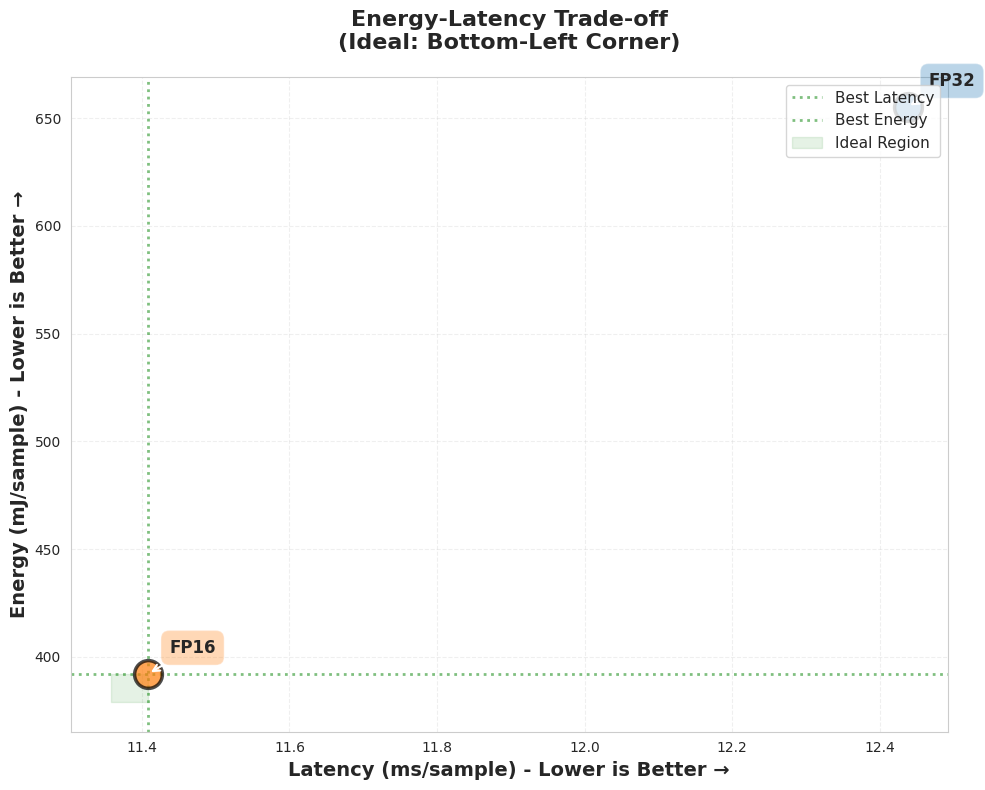

In [42]:
if df_results['energy_per_sample_mj'].max() > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = sns.color_palette('tab10', n_colors=len(df_results))
    
    # Scatter plot
    for i, row in df_results.iterrows():
        ax.scatter(row['mean_latency_ms'], row['energy_per_sample_mj'], 
                  s=400, c=[colors[i]], alpha=0.7, edgecolors='black', linewidth=2.5, zorder=3)
        
        # Add labels
        ax.annotate(row['name'], 
                   (row['mean_latency_ms'], row['energy_per_sample_mj']),
                   xytext=(15, 15), textcoords='offset points',
                   fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.3),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1.5))
    
    ax.set_xlabel('Latency (ms/sample) - Lower is Better →', fontsize=14, fontweight='bold')
    ax.set_ylabel('Energy (mJ/sample) - Lower is Better →', fontsize=14, fontweight='bold')
    ax.set_title('Energy-Latency Trade-off\n(Ideal: Bottom-Left Corner)', fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add ideal region shading
    best_latency = df_results['mean_latency_ms'].min()
    best_energy = df_results['energy_per_sample_mj'].min()
    
    ax.axvline(x=best_latency, color='green', linestyle=':', linewidth=2, alpha=0.5, label='Best Latency')
    ax.axhline(y=best_energy, color='green', linestyle=':', linewidth=2, alpha=0.5, label='Best Energy')
    
    # Shade ideal quadrant
    ax.fill_between([ax.get_xlim()[0], best_latency], 
                     ax.get_ylim()[0], best_energy, 
                     color='green', alpha=0.1, label='Ideal Region')
    
    ax.legend(fontsize=11, loc='upper right')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Energy data not available - skipping Energy vs Latency plot")

### Figure 10: Energy vs Latency Trade-off

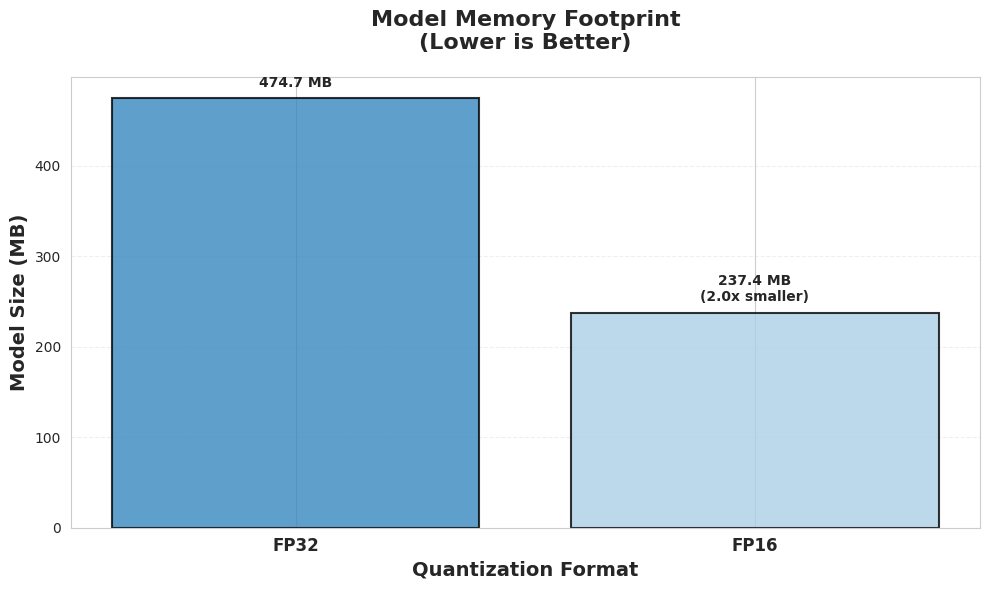

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('Blues_r', n_colors=len(df_results))

x_pos = np.arange(len(df_results))
bars = ax.bar(x_pos, df_results['model_size_mb'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Quantization Format', fontsize=14, fontweight='bold')
ax.set_ylabel('Model Size (MB)', fontsize=14, fontweight='bold')
ax.set_title('Model Memory Footprint\n(Lower is Better)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(df_results['name'], fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(df_results.iterrows()):
    reduction = row['size_reduction_vs_fp32']
    label = f"{row['model_size_mb']:.1f} MB"
    if reduction > 1.0:
        label += f"\n({reduction:.1f}x smaller)"
    ax.text(i, row['model_size_mb'] + max(df_results['model_size_mb'])*0.02, 
            label, 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Figure 9: Model Size Comparison

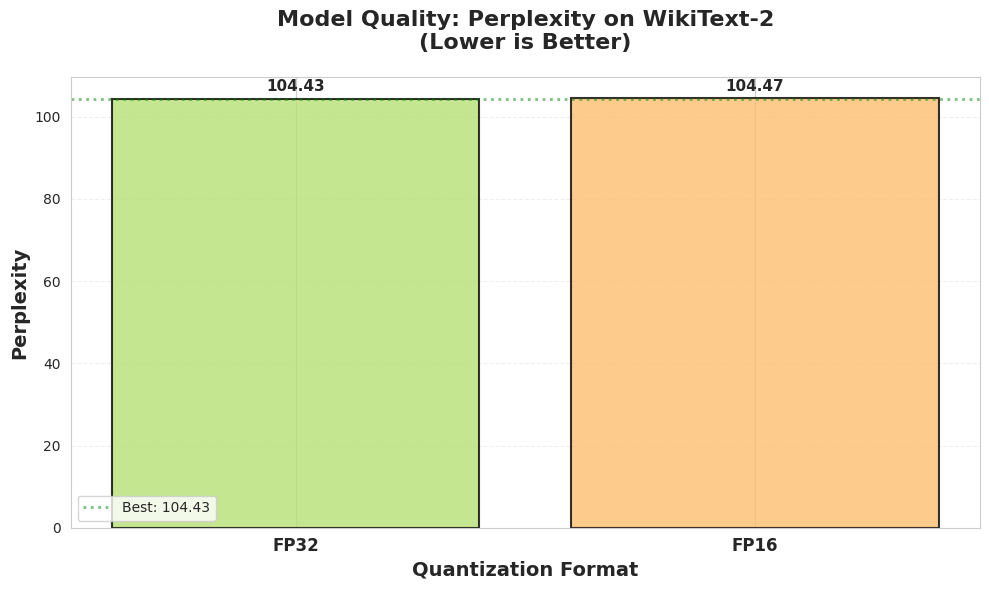

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('RdYlGn_r', n_colors=len(df_results))

x_pos = np.arange(len(df_results))
bars = ax.bar(x_pos, df_results['perplexity'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Quantization Format', fontsize=14, fontweight='bold')
ax.set_ylabel('Perplexity', fontsize=14, fontweight='bold')
ax.set_title('Model Quality: Perplexity on WikiText-2\n(Lower is Better)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(df_results['name'], fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(df_results.iterrows()):
    ax.text(i, row['perplexity'] + max(df_results['perplexity'])*0.01, 
            f"{row['perplexity']:.2f}", 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add horizontal line for best perplexity
best_ppl = df_results['perplexity'].min()
ax.axhline(y=best_ppl, color='green', linestyle=':', linewidth=2, alpha=0.5, label=f'Best: {best_ppl:.2f}')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

### Figure 8: Model Perplexity (Quality Metric)

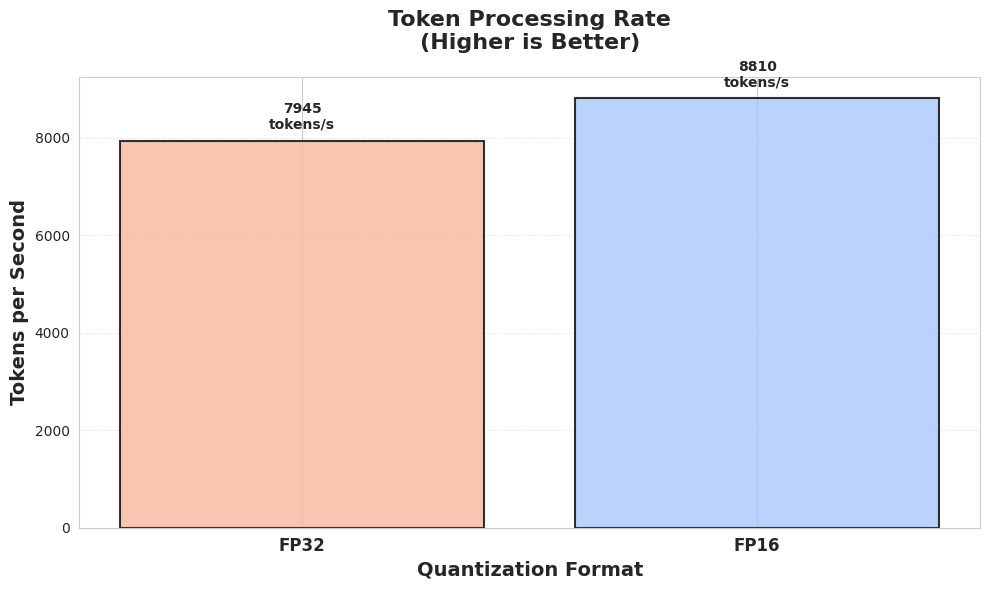

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('coolwarm', n_colors=len(df_results))[::-1]

x_pos = np.arange(len(df_results))
bars = ax.bar(x_pos, df_results['tokens_per_sec'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Quantization Format', fontsize=14, fontweight='bold')
ax.set_ylabel('Tokens per Second', fontsize=14, fontweight='bold')
ax.set_title('Token Processing Rate\n(Higher is Better)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(df_results['name'], fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(df_results.iterrows()):
    ax.text(i, row['tokens_per_sec'] + max(df_results['tokens_per_sec'])*0.02, 
            f"{row['tokens_per_sec']:.0f}\ntokens/s", 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Figure 7: Tokens per Second

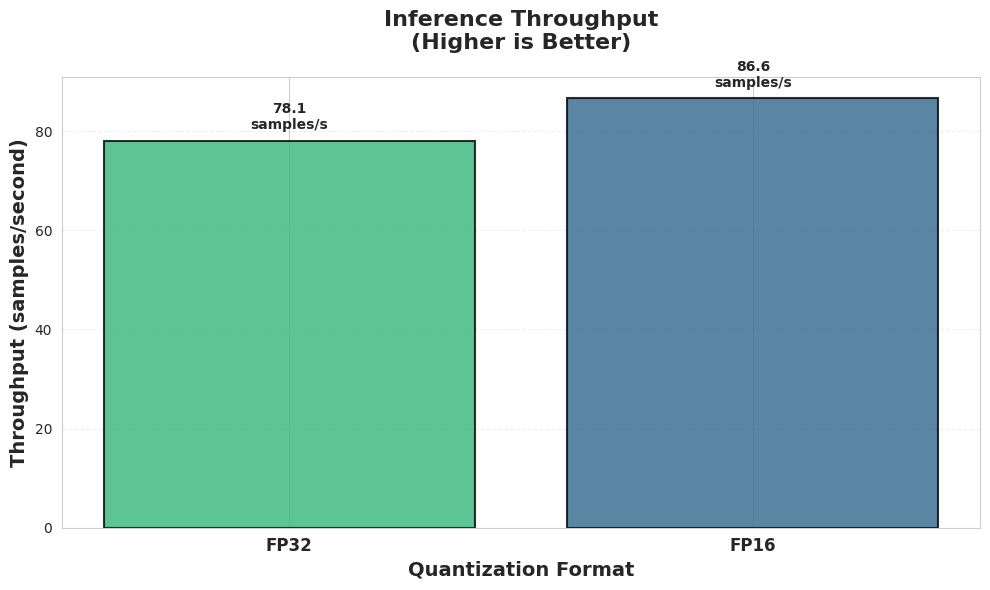

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('viridis', n_colors=len(df_results))[::-1]

x_pos = np.arange(len(df_results))
bars = ax.bar(x_pos, df_results['throughput'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Quantization Format', fontsize=14, fontweight='bold')
ax.set_ylabel('Throughput (samples/second)', fontsize=14, fontweight='bold')
ax.set_title('Inference Throughput\n(Higher is Better)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(df_results['name'], fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(df_results.iterrows()):
    ax.text(i, row['throughput'] + max(df_results['throughput'])*0.02, 
            f"{row['throughput']:.1f}\nsamples/s", 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Figure 6: Throughput (Samples/Second)

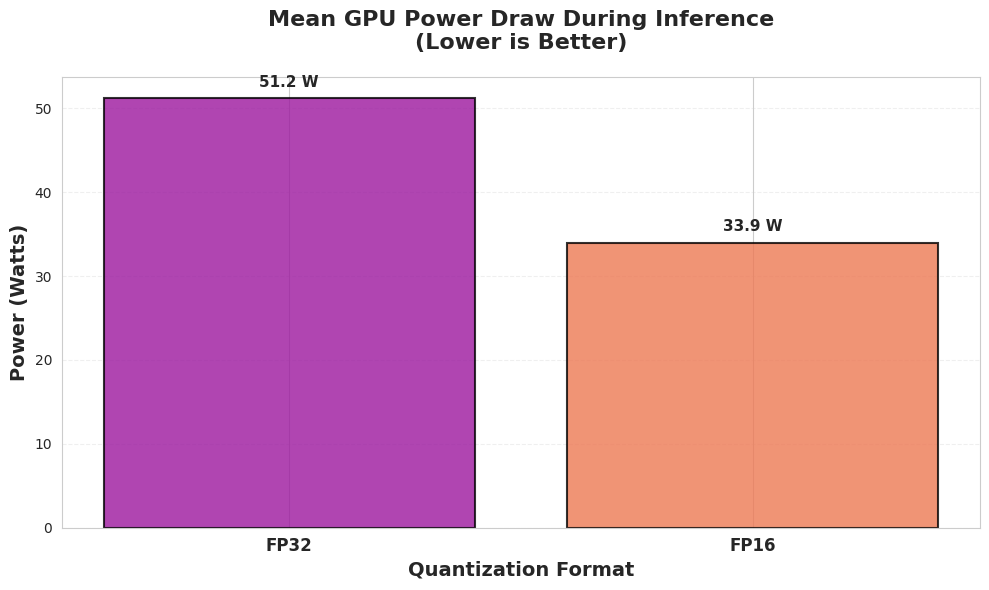

In [47]:
if df_results['mean_power_w'].max() > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette('plasma', n_colors=len(df_results))
    
    x_pos = np.arange(len(df_results))
    bars = ax.bar(x_pos, df_results['mean_power_w'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Quantization Format', fontsize=14, fontweight='bold')
    ax.set_ylabel('Power (Watts)', fontsize=14, fontweight='bold')
    ax.set_title('Mean GPU Power Draw During Inference\n(Lower is Better)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(df_results['name'], fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(df_results.iterrows()):
        ax.text(i, row['mean_power_w'] + max(df_results['mean_power_w'])*0.02, 
                f"{row['mean_power_w']:.1f} W", 
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Power data not available (GPU power monitoring not functional)")

### Figure 5: Mean Power Draw

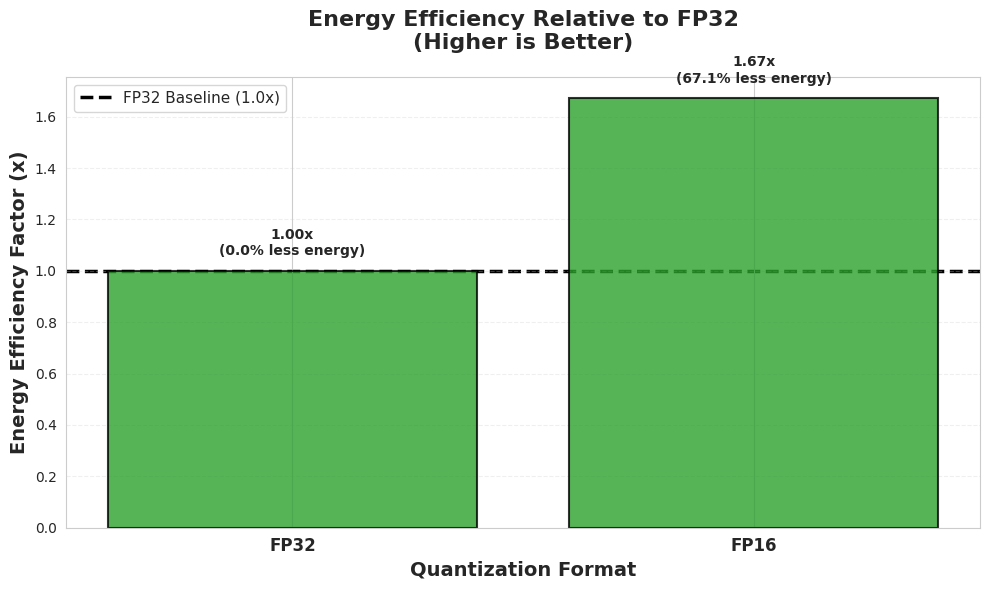

In [48]:
if df_results['energy_per_sample_mj'].max() > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    colors_energy = ['#d62728' if x < 1.0 else '#2ca02c' for x in df_results['energy_reduction_vs_fp32']]
    
    x_pos = np.arange(len(df_results))
    bars = ax.bar(x_pos, df_results['energy_reduction_vs_fp32'], color=colors_energy, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add baseline reference
    ax.axhline(y=1.0, color='black', linestyle='--', linewidth=2.5, label='FP32 Baseline (1.0x)', zorder=0)
    
    ax.set_xlabel('Quantization Format', fontsize=14, fontweight='bold')
    ax.set_ylabel('Energy Efficiency Factor (x)', fontsize=14, fontweight='bold')
    ax.set_title('Energy Efficiency Relative to FP32\n(Higher is Better)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(df_results['name'], fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.legend(fontsize=11, loc='upper left')
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(df_results.iterrows()):
        efficiency = row['energy_reduction_vs_fp32']
        label = f"{efficiency:.2f}x"
        if efficiency >= 1.0:
            label += f"\n({(efficiency-1)*100:.1f}% less energy)"
        else:
            label += f"\n({(1-efficiency)*100:.1f}% more energy)"
        
        y_offset = 0.05 if efficiency >= 1.0 else -0.05
        va = 'bottom' if efficiency >= 1.0 else 'top'
        ax.text(i, efficiency + y_offset, label, 
                ha='center', va=va, fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Energy data not available (GPU power monitoring not functional)")

### Figure 4: Energy Efficiency vs FP32

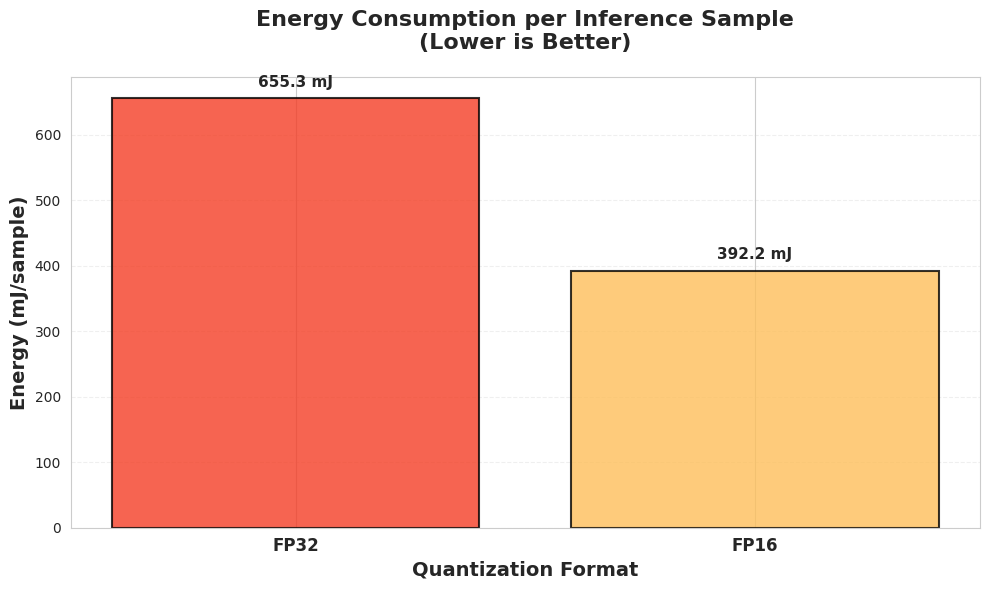

In [49]:
if df_results['energy_per_sample_mj'].max() > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = sns.color_palette('YlOrRd', n_colors=len(df_results))[::-1]
    
    x_pos = np.arange(len(df_results))
    bars = ax.bar(x_pos, df_results['energy_per_sample_mj'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Quantization Format', fontsize=14, fontweight='bold')
    ax.set_ylabel('Energy (mJ/sample)', fontsize=14, fontweight='bold')
    ax.set_title('Energy Consumption per Inference Sample\n(Lower is Better)', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(df_results['name'], fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(df_results.iterrows()):
        ax.text(i, row['energy_per_sample_mj'] + max(df_results['energy_per_sample_mj'])*0.02, 
                f"{row['energy_per_sample_mj']:.1f} mJ", 
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Energy data not available (GPU power monitoring not functional)")

### Figure 3: Energy Consumption per Sample

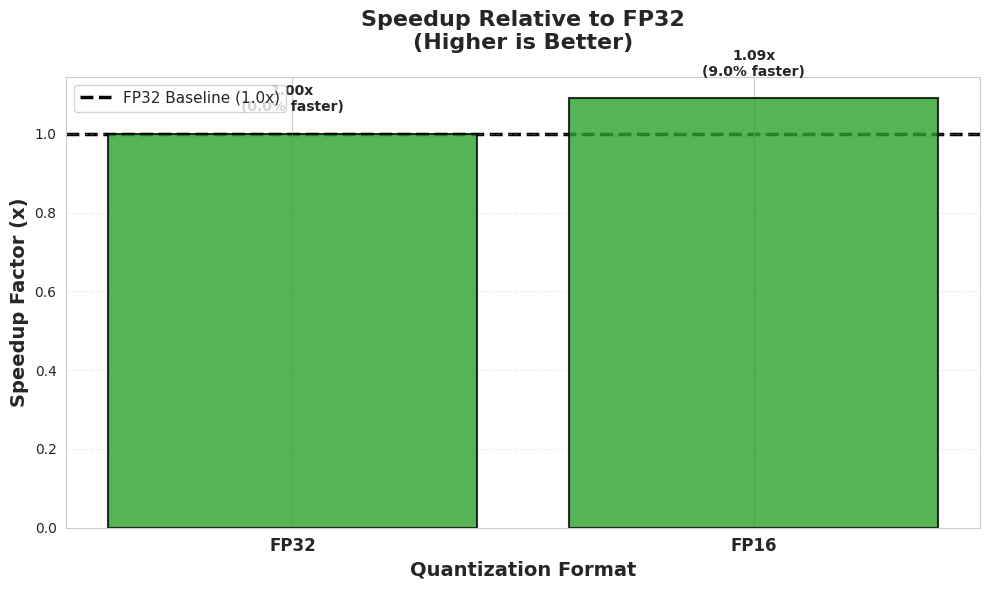

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))
colors_speedup = ['#d62728' if x < 1.0 else '#2ca02c' for x in df_results['speedup_vs_fp32']]

x_pos = np.arange(len(df_results))
bars = ax.bar(x_pos, df_results['speedup_vs_fp32'], color=colors_speedup, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add baseline reference
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=2.5, label='FP32 Baseline (1.0x)', zorder=0)

ax.set_xlabel('Quantization Format', fontsize=14, fontweight='bold')
ax.set_ylabel('Speedup Factor (x)', fontsize=14, fontweight='bold')
ax.set_title('Speedup Relative to FP32\n(Higher is Better)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(df_results['name'], fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='upper left')

# Add value labels on bars
for i, (idx, row) in enumerate(df_results.iterrows()):
    speedup = row['speedup_vs_fp32']
    label = f"{speedup:.2f}x"
    if speedup >= 1.0:
        label += f"\n({(speedup-1)*100:.1f}% faster)"
    else:
        label += f"\n({(1-speedup)*100:.1f}% slower)"
    
    y_offset = 0.05 if speedup >= 1.0 else -0.05
    va = 'bottom' if speedup >= 1.0 else 'top'
    ax.text(i, speedup + y_offset, label, 
            ha='center', va=va, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Figure 2: Speedup vs FP32 Baseline

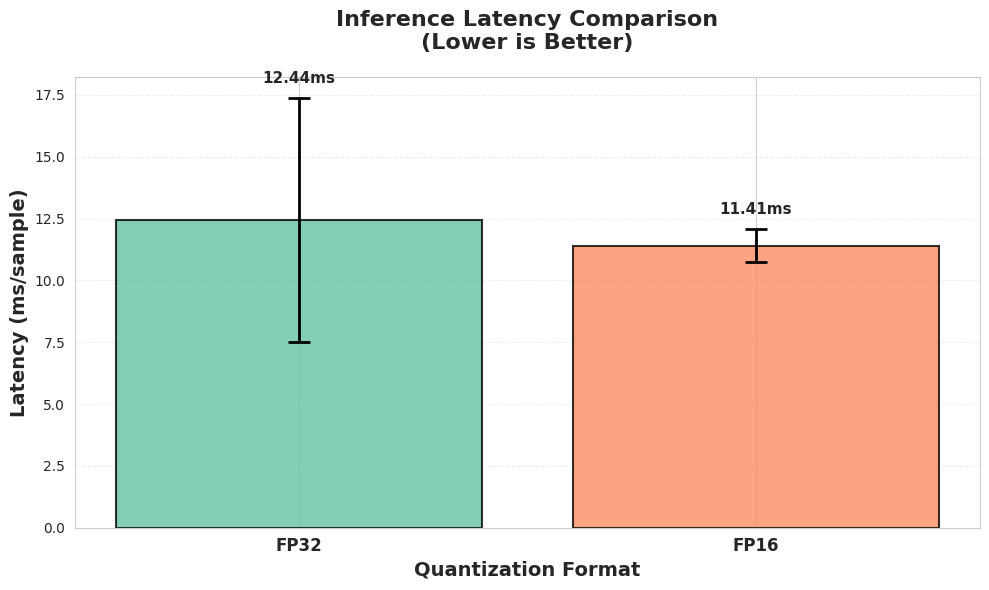

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('Set2', n_colors=len(df_results))

x_pos = np.arange(len(df_results))
bars = ax.bar(x_pos, df_results['mean_latency_ms'], color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.errorbar(x_pos, df_results['mean_latency_ms'], 
            yerr=df_results['std_latency_ms'], 
            fmt='none', color='black', capsize=8, linewidth=2, capthick=2)

ax.set_xlabel('Quantization Format', fontsize=14, fontweight='bold')
ax.set_ylabel('Latency (ms/sample)', fontsize=14, fontweight='bold')
ax.set_title('Inference Latency Comparison\n(Lower is Better)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(df_results['name'], fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(df_results.iterrows()):
    ax.text(i, row['mean_latency_ms'] + row['std_latency_ms'] + 0.5, 
            f"{row['mean_latency_ms']:.2f}ms", 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### Figure 1: Latency Comparison with Error Bars

## Extended Visualizations

The following sections provide comprehensive visualizations of all benchmark metrics, one figure per metric for detailed analysis.

## Export Results for Further Analysis

In [52]:
# Save results to CSV
output_dir = Path("../results")
output_dir.mkdir(exist_ok=True)

output_file = output_dir / "gpt2_quantization_benchmark_results.csv"
df_results.to_csv(output_file, index=False)
print(f"\n✓ Results saved to: {output_file}")

# Also save a summary markdown file
summary_file = output_dir / "gpt2_benchmark_summary.md"
with open(summary_file, 'w') as f:
    f.write("# GPT-2 Quantization Benchmark Summary\n\n")
    f.write(f"**Date:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"**Model:** {MODEL_NAME} (GPT-2 Small - 124M parameters)\n\n")
    f.write(f"**Dataset:** WikiText-2\n\n")
    f.write(f"**Device:** {device}\n\n")
    if torch.cuda.is_available():
        f.write(f"**GPU:** {torch.cuda.get_device_name(0)}\n\n")
    
    f.write("## Results\n\n")
    f.write(df_results.to_markdown(index=False))
    f.write("\n\n## Key Findings\n\n")
    
    if len(df_results) > 1:
        fastest = df_results.loc[df_results['mean_latency_ms'].idxmin()]
        f.write(f"- **Fastest:** {fastest['name']} ({fastest['speedup_vs_fp32']:.2f}x faster than FP32)\n")
        
        if df_results['energy_per_sample_mj'].max() > 0:
            most_efficient = df_results.loc[df_results['energy_per_sample_mj'].idxmin()]
            f.write(f"- **Most Efficient:** {most_efficient['name']} ({most_efficient['energy_reduction_vs_fp32']:.2f}x more efficient)\n")
        
        smallest = df_results.loc[df_results['model_size_mb'].idxmin()]
        f.write(f"- **Smallest:** {smallest['name']} ({smallest['size_reduction_vs_fp32']:.2f}x size reduction)\n")
        
        best_ppl = df_results.loc[df_results['perplexity'].idxmin()]
        f.write(f"- **Best Perplexity:** {best_ppl['name']} ({best_ppl['perplexity']:.2f})\n")

print(f"✓ Summary saved to: {summary_file}")

print("\n" + "="*70)
print("BENCHMARK COMPLETE")
print("="*70)


✓ Results saved to: ../results/gpt2_quantization_benchmark_results.csv
✓ Summary saved to: ../results/gpt2_benchmark_summary.md

BENCHMARK COMPLETE
